# Music Generator with Maestro dataset

## Word about the dataset
MAESTRO (MIDI and Audio Edited for Synchronous TRacks and Organization) is a dataset composed of about 200 hours of virtuosic piano performances captured with fine alignment (~3 ms) between note labels and audio waveforms.
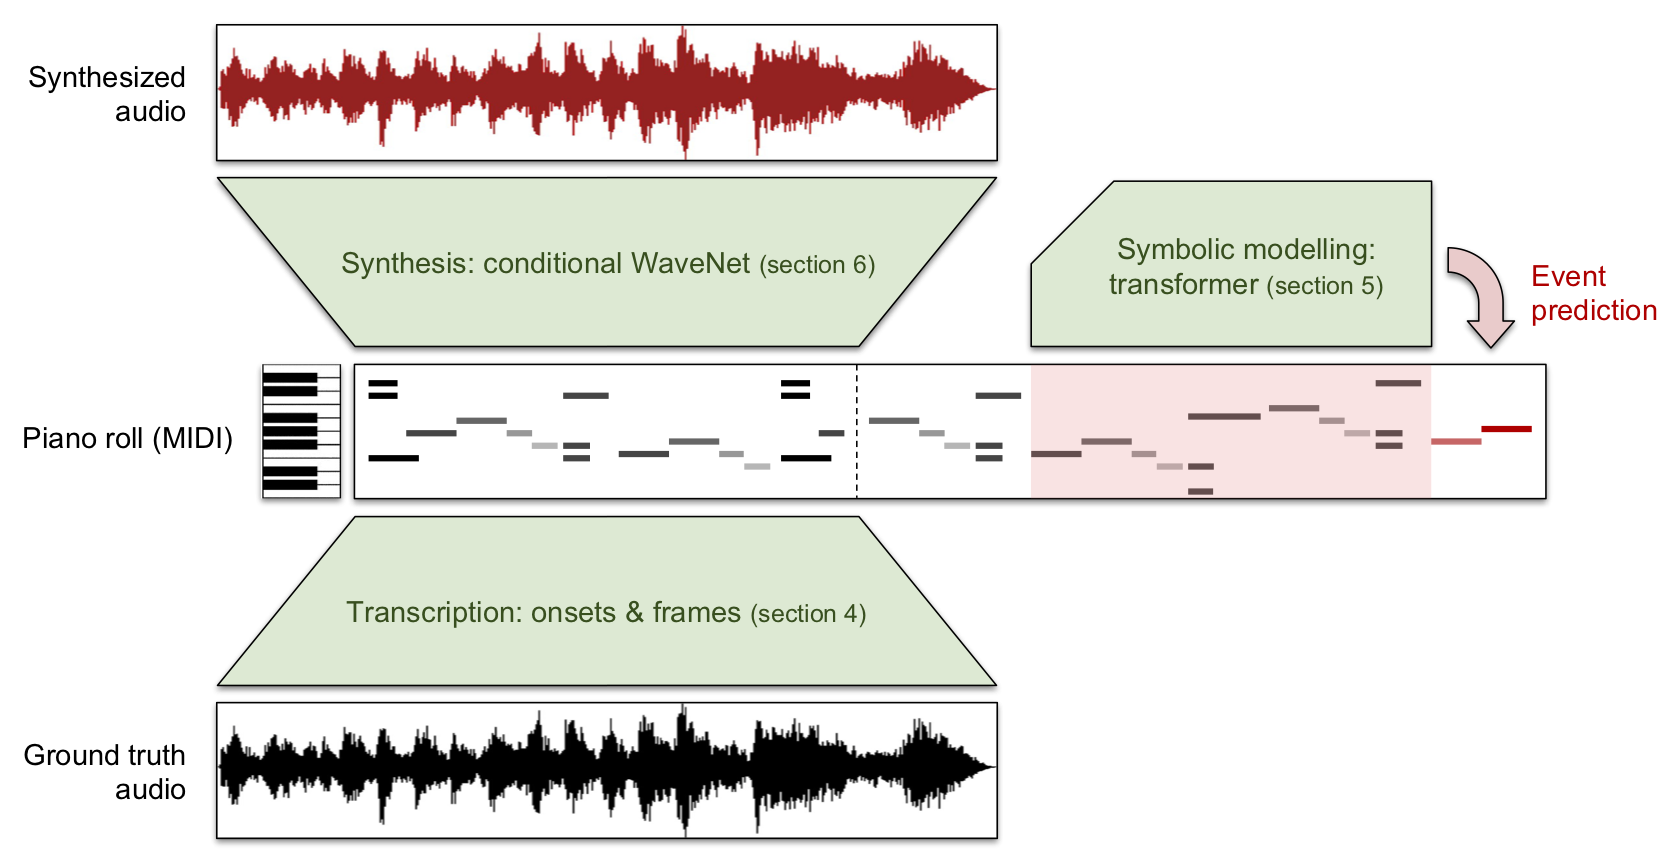
The dataset contains about 200 hours of paired audio and MIDI recordings from ten years of International Piano-e-Competition. The MIDI data includes key strike velocities and sustain/sostenuto/una corda pedal positions. Audio and MIDI files are aligned with ∼3 ms accuracy and sliced to individual musical pieces, which are annotated with composer, title, and year of performance. Uncompressed audio is of CD quality or higher (44.1–48 kHz 16-bit PCM stereo).

MAESTRO is provided as a zip file containing the MIDI and WAV files as well as metadata in CSV and JSON formats. A MIDI-only archive of the dataset is also available.

## Word about RNN

A recurrent neural network (RNN) is a class of artificial neural networks where connections between nodes form a directed or undirected graph along a temporal sequence. This allows it to exhibit temporal dynamic behavior. Derived from feedforward neural networks, RNNs can use their internal state (memory) to process variable length sequences of inputs.This makes them applicable to tasks such as unsegmented, connected handwriting recognition or speech recognition.Recurrent neural networks are theoretically Turing complete and can run arbitrary programs to process arbitrary sequences of inputs.

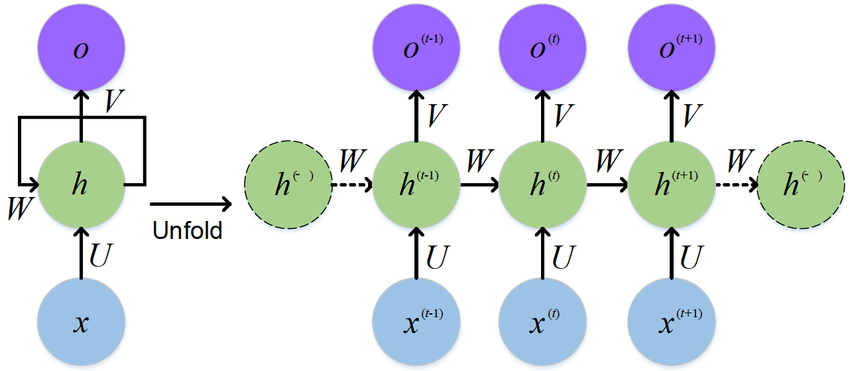

The term "recurrent neural network" is used to refer to the class of networks with an infinite impulse response, whereas "convolutional neural network" refers to the class of finite impulse response. Both classes of networks exhibit temporal dynamic behavior.A finite impulse recurrent network is a directed acyclic graph that can be unrolled and replaced with a strictly feedforward neural network, while an infinite impulse recurrent network is a directed cyclic graph that can not be unrolled.

Both finite impulse and infinite impulse recurrent networks can have additional stored states, and the storage can be under direct control by the neural network. The storage can also be replaced by another network or graph if that incorporates time delays or has feedback loops. Such controlled states are referred to as gated state or gated memory, and are part of long short-term memory networks (LSTMs) and gated recurrent units. This is also called Feedback Neural Network (FNN). 

## Importing necessary libraries

In [2]:
!apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi

import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 20 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
Get:4 http://archive.ub

## Handling MIDI files
MIDI stands for Musical Instrument Digital Interface and has been the rage among electronic musicians throughout its six year existence. It is a powerful tool for composers and teachers alike. It allows musicians to be more creative on stage and in the studio. It allows composers to write music that no human could ever perform. But it is NOT a tangible object, a thing to be had. MIDI is a communications protocol that allows electronic musical instruments to interact with each other. 

In [3]:
data_dir = pathlib.Path('data/maestro-v3.0.0')
if not data_dir.exists():
    tf.keras.utils.get_file(
        'maestro-v3.0.0-midi.zip',
        origin='https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip',
        extract=True,
        cache_dir='.', cache_subdir='data',
    )
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print("Number of MIDI files is {}".format(len(filenames)))

58416533/58416533 [==============================] - 1s 0us/step
Number of MIDI files is 1276


In [4]:
# setting up the random seed and the sampling rate
_SAMPLING_RATE = 16000
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
sample = np.random.choice(filenames)
print(sample)

data/maestro-v3.0.0/2011/MIDI-Unprocessed_07_R1_2011_MID--AUDIO_R1-D3_05_Track05_wav.midi


In [5]:
pm = pretty_midi.PrettyMIDI(sample)

Now we play the pm object generated from the sample file

In [6]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    # Take a sample of the generated waveform to mitigate kernel resets
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [7]:
display_audio(pm)

Now printing details of the instruments used in the clip

In [8]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [9]:
for i, note in enumerate(instrument.notes[0:10]):
    note_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=79, note_name=G5, duration=1.4010
1: pitch=76, note_name=E5, duration=1.5052
2: pitch=73, note_name=C#5, duration=1.5677
3: pitch=67, note_name=G4, duration=1.5807
4: pitch=95, note_name=B6, duration=1.8346
5: pitch=88, note_name=E6, duration=1.9922
6: pitch=83, note_name=B5, duration=2.0430
7: pitch=34, note_name=A#1, duration=1.2539
8: pitch=46, note_name=A#2, duration=1.4062
9: pitch=54, note_name=F#3, duration=1.9180


## Feature representation
First we will represent the features for the model using three values the pitch, step and duration. The pitch will be the true value of the note itself, the step is the duration between the start of the previous note and the current note and the duration is calcuated from the end of the note and its start.

In [10]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [11]:
sample_note = midi_to_notes(sample)
sample_note.head()

,pitch,start,end,step,duration
0,95,1.028646,2.863281,0.000000,1.834635
1,88,1.032552,3.024740,0.003906,1.992187
2,83,1.032552,3.075521,0.000000,2.042969
3,79,1.039062,2.440104,0.006510,1.401042
4,67,1.040365,2.621094,0.001302,1.580729


Getting the names of pitches rather than the numerical value

In [12]:
get_note_name = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_name(sample_note['pitch'])
sample_note_names[0:10]

array(['B6', 'E6', 'B5', 'G5', 'G4', 'E5', 'C#5', 'F#3', 'F#4', 'A#2'],
      dtype='<U3')

Defining a function to visualize a number of notes from an MIDI 

In [13]:
def plot_piano_note(notes, count=None):
    if count:
        title = f'First {count} notes'
    else:
        title = f'Whole track'

    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    _ = plt.title(title)

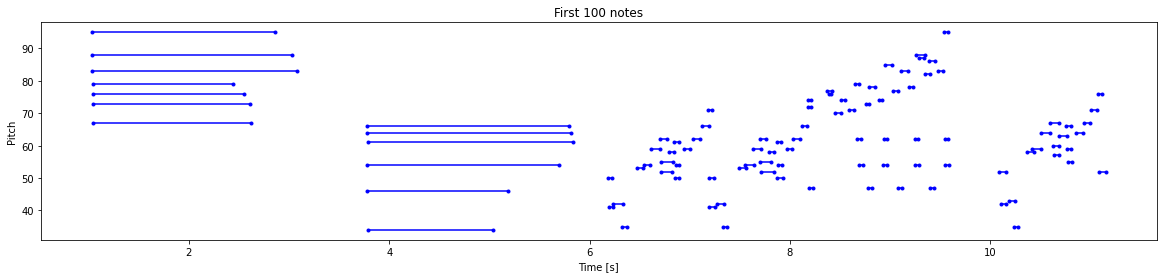

In [14]:
plot_piano_note(sample_note, 100)

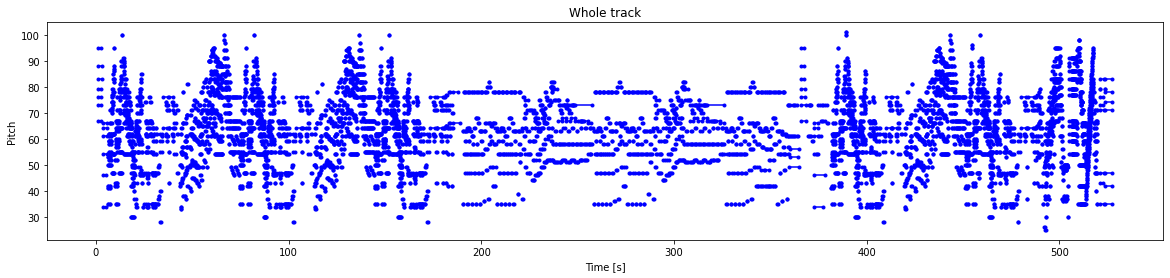

In [15]:
# plot whole sample
plot_piano_note(sample_note)

Now we check the note variables distributions

In [16]:
def plot_distributions(notes, drop_percentile=2.5):
    plt.figure(figsize=[15, 5])
    plt.subplot(1, 3, 1)
    sns.histplot(notes, x="pitch", bins=25)

    plt.subplot(1, 3, 2)
    max_step = np.percentile(notes['step'], 100 - drop_percentile)
    sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

    plt.subplot(1, 3, 3)
    max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
    sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

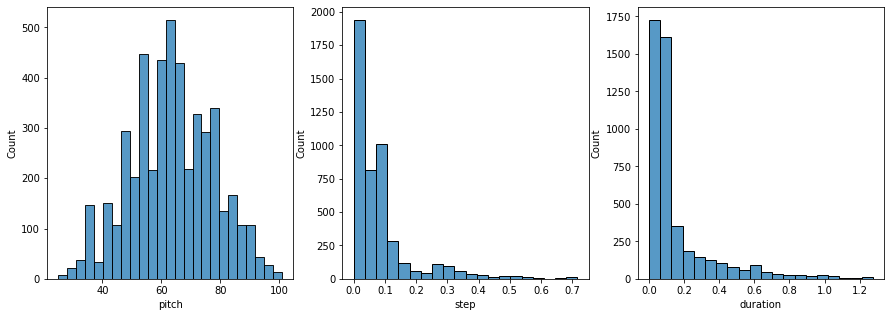

In [17]:
plot_distributions(sample_note)

Creating a function to convert the notes dataframe into MIDI file

In [18]:
def notes_to_midi(notes, out_file, instrument_name, loadness=100):

    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program(instrument_name))

    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        note = pretty_midi.Note(velocity=loadness, pitch=int(note['pitch']),start=start,end=end)
        instrument.notes.append(note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

In [19]:
ex = notes_to_midi(sample_note, "/notes_to_midi_rev.midi", instrument_name)

In [20]:
display_audio(ex)

## Create the training dataset
Creating the training dataset by extracting notes from the MIDI files.

In [21]:
all_notes = []
for f in filenames[0:15]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [22]:
all_notes.head()

,pitch,start,end,step,duration
0,63,1.023438,2.029948,0.000000,1.006510
1,44,1.058594,3.363281,0.035156,2.304688
2,51,1.700521,1.944010,0.641927,0.243490
3,59,2.113281,3.300781,0.412760,1.187500
4,51,2.502604,2.674479,0.389323,0.171875


In [23]:
print("Number of notes is {}".format(len(all_notes)))

Number of notes is 98714


In [24]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [25]:
# converting the numpy array into tensorflow dataset
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

We will train the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and the next note as the label. In this way, the model will be trained to predict the next note in a sequence. 

In [26]:
def create_sequences(dataset, seq_length,vocab_size = 128,):
    """Returns TF Dataset of sequence and label examples."""
    seq_length = seq_length+1

    # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=1,drop_remainder=True)

    # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    # Normalize note pitch
    def scale_pitch(x):
        x = x/[vocab_size,1.0,1.0]
        return x

    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

        return scale_pitch(inputs), labels

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [30]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [31]:
batch_size = 64
n_notes = len(all_notes)
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds.shuffle(buffer_size).batch(batch_size, drop_remainder=True).cache().prefetch(tf.data.experimental.AUTOTUNE))

In [32]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

## Creating the model

In [33]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 256)          135168      ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            257         ['bidirectional[0][0]']          
                                                                                                  
 pitch (Dense)                  (None, 128)          32896       ['bidirectional[0][0]']          
                                                                                              

In [34]:
losses = model.evaluate(train_ds, return_dict=True)
losses

1542/1542 [==============================] - 64s 32ms/step - loss: 5.8670 - duration_loss: 0.9580 - pitch_loss: 4.8459 - step_loss: 0.0632


{'loss': 5.867027759552002,
 'duration_loss': 0.9579610824584961,
 'pitch_loss': 4.845866680145264,
 'step_loss': 0.06320171058177948}

In [35]:
model.compile(loss=loss,loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [36]:
model.evaluate(train_ds, return_dict=True)

1542/1542 [==============================] - 52s 32ms/step - loss: 1.2635 - duration_loss: 0.9580 - pitch_loss: 4.8459 - step_loss: 0.0632


{'loss': 1.263455867767334,
 'duration_loss': 0.9579610824584961,
 'pitch_loss': 4.845866680145264,
 'step_loss': 0.06320171058177948}

In [37]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [38]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
1542/1542 [==============================] - 123s 78ms/step - loss: 0.3943 - duration_loss: 0.1337 - pitch_loss: 4.0904 - step_loss: 0.0560
Epoch 2/50
1542/1542 [==============================] - 122s 79ms/step - loss: 0.3804 - duration_loss: 0.1288 - pitch_loss: 3.9819 - step_loss: 0.0525
Epoch 3/50
1542/1542 [==============================] - 122s 79ms/step - loss: 0.3760 - duration_loss: 0.1265 - pitch_loss: 3.9597 - step_loss: 0.0515
Epoch 4/50
1542/1542 [==============================] - 119s 77ms/step - loss: 0.3706 - duration_loss: 0.1242 - pitch_loss: 3.9260 - step_loss: 0.0501
Epoch 5/50
1542/1542 [==============================] - 122s 79ms/step - loss: 0.3669 - duration_loss: 0.1224 - pitch_loss: 3.8897 - step_loss: 0.0500
Epoch 6/50
1542/1542 [==============================] - 119s 77ms/step - loss: 0.3626 - duration_loss: 0.1205 - pitch_loss: 3.8706 - step_loss: 0.0485
Epoch 7/50
1542/1542 [==============================] - 122s 79ms/step - loss: 0.3598 - durati

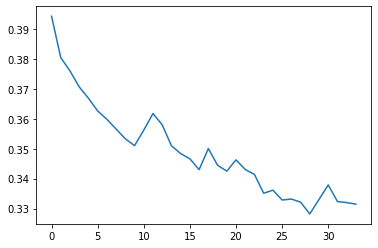

In [39]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

Now we create a function to predict a sequence of notes depending on a given input sequence with a temprature variable to control randomness of the output sequence.

In [53]:
def predict_next_note(notes, keras_model, temperature = 1.0):
    """Generates a note IDs using a trained sequence model."""

    assert temperature > 0

    # Add batch dimension
    inputs = tf.expand_dims(notes, 0)

    predictions = model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)

    # `step` and `duration` values should be non-negative
    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)


In [90]:
temperature = 2.0
num_predictions = 400

sample_notes = np.stack([sample_note[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

generated_notes = pd.DataFrame(generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 23ms/step


In [91]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,42,0.157491,0.202410,0.157491,0.359901
1,94,0.116041,0.208098,0.273532,0.481630
2,89,0.123636,0.346526,0.397168,0.743695
3,86,0.111470,0.380853,0.508638,0.889491
4,87,0.112331,0.403936,0.620969,1.024905
5,87,0.110168,0.374784,0.731137,1.105921
6,94,0.093433,0.488996,0.824571,1.313566
7,87,0.143639,0.260459,0.968209,1.228668
8,72,0.125788,0.378256,1.093997,1.472253
9,94,0.116940,0.394324,1.210937,1.605261


In [97]:
out = notes_to_midi(generated_notes, "predicted.midi", instrument_name)

In [98]:
display_audio(out)

In [95]:
generated_notes.to_csv(r'out_df.csv', index=True)

In [100]:
from google.colab import files
files.download("predicted.midi")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

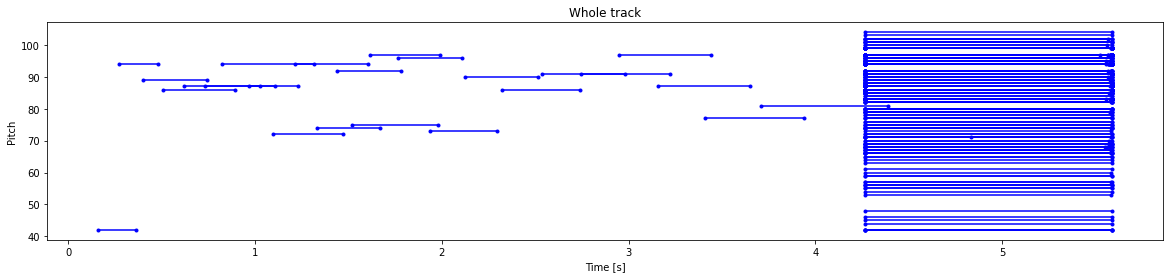

In [101]:
plot_piano_note(generated_notes)

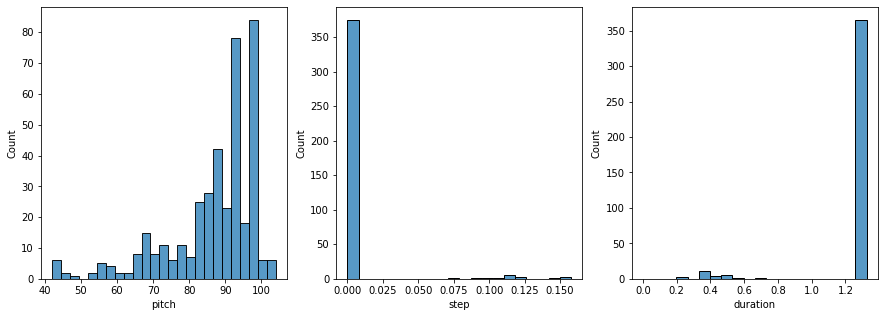

In [103]:
plot_distributions(generated_notes)

In [104]:
!pip install midi2audio
from midi2audio import FluidSynth
# using the default sound font in 44100 Hz sample rate
fs = FluidSynth()
fs.midi_to_audio('predicted.midi', 'predicted_wav.wav')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
